# Automatic SDS-PAGE Gel Annotation with Python

Load the necessary modules.

In [1]:
import numpy as np
from scipy import signal
import peakutils
import matplotlib.pyplot as plt 
from PIL import Image
import cv2
import plotly
import plotly.graph_objs as go

## Demonstrate loading raw data

Edit the file name below to point at your data. 

In [2]:
gel_file = "screen_grab_of_demo_gel.png"

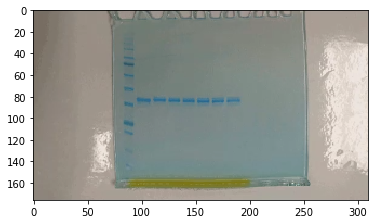

In [3]:
#%% Example of how it works

image = cv2.imread(gel_file)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#Either specify here or specifiy when the function is called
gel_lanes=12

#Edit the markers to your own ones!
markers=['200','140','136','110','87','62','51','40','30','22','16']
lane_labels=['Lane'+str(x) for x in range(1,gel_lanes+1)]

#Show the image that has been loaded - WARNING - needs to be in the correct orientation for it work!
plt.imshow(image, cmap='gray');

## Demonstrating the masking to find the gel

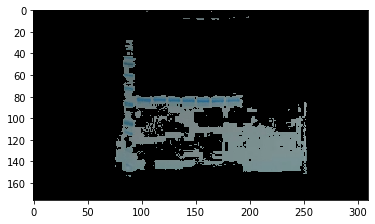

In [4]:
# The image must be converted to hsv for the filtering to work
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# define range of blue color in HSV
lower_blue = np.array([90,0,90])
upper_blue = np.array([230,255,255])

mask = cv2.inRange(hsv, lower_blue, upper_blue)
#np.argwhere(mask)

# View the mask to check it has done the correct job, otherwise the filters might need to be changed
res = cv2.bitwise_and(image,image, mask= mask)
plt.imshow(res, cmap='gray');

## Demonstrating cropping to the gel

Uses the mask method of detecting the gel to then crop to the gel.

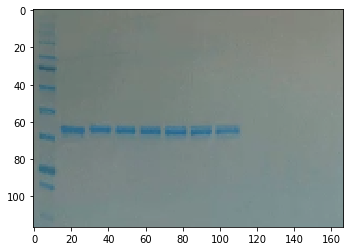

In [5]:
def crop_to_colour(image):
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower_blue = np.array([90,0,90])
    upper_blue = np.array([230,255,255])

    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    coords = np.argwhere(mask)
    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)
    x_20=int((x_max-x_min)*0.12)
    y_20=int((y_max-y_min)*0.03)
    cropped = image[x_min+x_20:x_max-x_20, y_min+y_20:y_max-y_20]
    return cropped

cropped=crop_to_colour(image)
plt.imshow(cropped, cmap='gray');

## Demonstrate Detecting the Marker Postions

Edit the markers to match yours.

As written, the marker needs to be in the first lane.

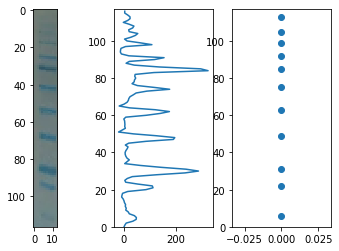

In [6]:
#Edit the markers to your own ones!
markers=['200','140','136','110','87','62','51','40','30','22','16']
lane_labels=['Lane'+str(x) for x in range(1,gel_lanes+1)]



def flatten_for_plot(data, axis):
    single=[]
    for y in data:
        single.append(np.sum(y)/3)
        
    single=np.array(single)  
    return single

first_lane=cropped[0:len(cropped),0:int(len(cropped[0])/gel_lanes)]

# Sum all of the darkest coloured pixels in the first lane 
first_lane_flat=flatten_for_plot(first_lane, 1)

# Needs to be inversed to make the numbers positive
inverse=list(map(lambda x: 1-x, first_lane_flat))

# Neat little tool for estimating the baseline
base = peakutils.baseline(np.array(inverse))

# Neat little tool for finding peaks - these are the markers!
peaks=signal.find_peaks(inverse-base, prominence=20.2)
#print(len(peaks[0]))
#print(len(markers))
assert len(peaks[0]) == len(markers), ("Signal peak in marker lane doesn't "
    "match number of markers.\n{} signal peaks detected in marker lane. {} "
    "marker bands expected.\nAdjust prominence setting appropriately.".format(
    len(peaks[0]),len(markers)))
        
#View the result of marker selection using matplotlib

plt.subplot(1,3,1)
plt.imshow(first_lane, cmap='gray')
plt.subplot(1,3,2)
plt.ylim((0,len(inverse)))
plt.plot(list(reversed(inverse-base)), range(0,len(inverse)), marker=None, linestyle='-')
plt.subplot(1,3,3)
plt.ylim((0,len(inverse)))
plt.scatter([0]*len(peaks[0]),list(map(lambda x: np.max(len(inverse))-x, peaks[0])))
plt.show();

## Demonstrate annotating the gel

In [20]:
def plotly_gel_output(image,marker_text,marker_positions,lanes):
    
    pil_img = Image.fromarray(image)
    
    img_width = len(image[0])
    img_height = len(image)
    abs_width = 900
    scale_factor = abs_width/img_width
    
    first_lane_pos=int((img_width*scale_factor/lanes)/2)
    last_lane_pos=int((img_width*scale_factor)-((img_width*scale_factor/gel_lanes)/2))
    intervals=int((last_lane_pos-first_lane_pos)/(lanes-1))
    
    

    layout= go.Layout(
            width = img_width*scale_factor,
            height = img_height*scale_factor,
            showlegend=True,
            xaxis = go.layout.XAxis(
                    visible = True,
                    range = [0, img_width*scale_factor],
                    showgrid = False, 
                    title='',
                    mirror='all',
                    side='top',
                    ticks='outside',
                    tick0=0,
                    dtick=100,
                    ticklen=8,
                    tickwidth=4,
                    tickcolor='#000',
                    linewidth=4,
                    linecolor='#000',
                    tickmode = 'array',
                    tickvals = [x for x in range(first_lane_pos,last_lane_pos,intervals)],
                    ticktext = list(range(1,lanes+1))), 
                    #ticktext = list(map(lambda x: x*scale_factor, lanes)),
                    #tickvals = list(map(lambda x: x*scale_factor, lanes))), 
            yaxis = go.layout.YAxis(
                    visible=True,
                    range = [0, img_height*scale_factor],
                    showgrid = False, 
                    title='(kDa)',
                    mirror='all',
                    ticks='outside',
                    tick0=0,
                    dtick=100,
                    ticklen=8,
                    tickwidth=4,
                    tickcolor='#000',
                    linewidth=4,
                    linecolor='#000',
                    tickmode = 'array',
                    tickvals = list(map(lambda x: (img_height*scale_factor)-(x*scale_factor), marker_positions)),
                    ticktext = marker_text,),
                    # the scaleanchor attribute ensures that the aspect ratio stays constant
                    # scaleanchor = 'x'),
            font=dict(color='rgb(0,0,0)',size=24),
            margin=go.layout.Margin(
                        l=100,
                        r=50,
                        b=100,
                        t=100,
                        pad=0
                        ),
            images= [dict(
                  source= pil_img,
                  xref= "x",
                  yref= "y",
                  x= 0,
                  y= img_height*scale_factor,
                  sizex= img_width*scale_factor,
                  sizey= img_height*scale_factor,
                  sizing= "stretch",
                  opacity= 1,
                  layer= "below")])

    traces=[]
    for x in range(1,gel_lanes+1):
        trace= go.Scatter(
                    name=str(x)+': Lane '+str(x),
                    x=[0, img_width*scale_factor],
                    y=[0, img_height*scale_factor],
                    mode='markers',
                    marker={'color': '#000',
                            'opacity' : 0})
        traces.append(trace)
        
    fig = go.Figure(data=traces,layout=layout)
    
    
#    fig = go.Figure(data=[{
#            'x': [0, img_width*scale_factor], 
#            'y': [0, img_height*scale_factor], 
#                'mode': 'markers',
#                'marker': {'opacity': 1}}],layout = layout)
    
    plotly.offline.plot(fig, filename='gel_test.html')
    
def plot_gel_image(input_gel,gel_lanes=12,markers=['200','140','136','110','87','62','51','40','30','22','16']):
    
    image = cv2.imread(input_gel)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    #gel_lanes=12
    #markers=['200','140','136','110','87','62','51','40','30','22','16']
    #lane_labels=['Lane'+str(x) for x in range(1,gel_lanes+1)]

    cropped=crop_to_colour(image)    
    first_lane=cropped[0:len(cropped),0:int(len(cropped[0])/gel_lanes)]
    first_lane_flat=flatten_for_plot(first_lane, 1)
    inverse=list(map(lambda x: 1-x, first_lane_flat))    
    base = peakutils.baseline(np.array(inverse))
    peaks=signal.find_peaks(inverse-base, prominence=500)

    plotly_gel_output(cropped,markers,peaks[0],gel_lanes)
  
    
def get_layout():
    layout = go.Layout(
                    autosize = False, 
                    showlegend=True, 
                    legend=dict(
                            traceorder='normal',
                            font=dict(
                                    size=18,
                                    color='#000')),
                    height = 600,  
                    width = 900, 
                    yaxis = dict(showgrid = False, 
                                 tickmode='linear',
                                 title='Pixel Density',
                                 mirror=True,
                                 #range=[0,32],
                                 ticks='outside',
                                 tick0=0,
                                 dtick=1000,
                                 ticklen=8,
                                 tickwidth=2,
                                 tickcolor='#000',
                                 linewidth=4,
                                 linecolor='#000',), 
                    font=dict(color='rgb(0,0,0)',size=24),
                    xaxis = dict(
                            #zeroline = True,
                            showgrid = False,
                            #range=[0,2.4],
                            tickmode='linear',
                            tickangle=45,
                            mirror=True,
                            title='Gel Migration',
                            ticks='outside',
                            tick0=0,
                            dtick=100,
                            ticklen=8,
                            tickwidth=2,
                            tickcolor='#000',
                            linewidth=4,
                            linecolor='#000',
                            ),
                    margin=go.layout.Margin(
                        l=100,
                        r=50,
                        b=100,
                        t=100,
                        pad=0
                        ),
                    )
    return layout

def plotly_plot_lanes(image,gel_lanes=12):
    
    lane_length=int(len(image[0])/gel_lanes)
    
    traces=[]
    lane=1
    for x in range(0,lane_length*gel_lanes,lane_length):
        flat=flatten_for_plot(image[0:len(image),x:x+lane_length], 1) 
        inverse=list(map(lambda x: 1-x, flat))
        base= peakutils.baseline(np.array(inverse))
        trace= go.Scatter(
                    name=str(lane)+': Lane '+str(lane),
                    x=list(range(0,len(inverse))),
                    y=inverse-base,
                    mode='lines',)
        traces.append(trace)
        lane=lane+1
    fig = go.Figure(data=traces, layout=get_layout())
    plotly.offline.plot(fig, filename='gel_lanes.html')
    

#Plot the cropped image using plotly to make it look nice
plotly_gel_output(cropped,markers,peaks[0],gel_lanes)

In [21]:
from IPython.display import IFrame
IFrame(src='gel_test.html', width=900, height=650)

## Demonstrating Plotting the Bands in the Lanes

In [23]:
#Plot the gel lanes using plotly to make it look nice
plotly_plot_lanes(cropped,gel_lanes=12)

In [24]:
from IPython.display import IFrame
IFrame(src='gel_lanes.html', width=900, height=650)